In [1]:
import time
import pandas as pd
import joblib
import xgboost as xgb

from typing import List, NamedTuple
import sys

sys.path.append("./")
sys.path.append("../..")
from models.tabnet_proba import TabNetRegressorProba
from pytorch_tabnet.tab_model import TabNetRegressor

data_folder = "../data/2020-2024/{}/version_{}/{}/"

class Config(NamedTuple):
    data_version: str = "2024-05-19"
    res_version: str = "2024-06-24"
    model_type: str = "_full"
    model_combination: str = "ngb"
    model_name: str = "NGBoost"
    predictors_prob: List[str] = ["baseline", "predictions"]
    model_names_prob: List[str] =["Baseline", "NGBoost (full model)"],
    model_names_det: List[str] =["Daily profile", "NGBoost (full model)"],    
    predictors_det: List[str] = ["daily_profile", "predictions"]
    scaler_str: str = "yeo_johnson"
    scaled: str = "_scaled"
    explanations: str ="_partition" 


In [ ]:

configurations = {
    "NGBoost": Config(),
    "XGBoost": Config(
        res_version="2024-05-19",
        model_combination="xgb",
        model_name="XGBoost",
        predictors_det=["daily_profile", "predictions"],
        model_names_det=["Daily profile", "XGBoost"],
        scaler_str="",
        scaled="",
        explanations="_partition"
    ),
    "TabNet": Config(
        res_version="2024-09-20",
        model_combination="tabnet_det_rs",
        model_name="TabNet",
        predictors_det=["daily_profile", "predictions"],
        model_names_det=["Daily profile", "TabNet"],
        scaler_str="yeo_johnson",
        scaled="_scaled",
        explanations="_partition"
    ),
    "TabNetProba": Config(
        res_version="2024-08-27",
        model_combination="tabnet_proba_final",
        model_name="TabnetProba",
        model_names_det=["Daily profile", "TabNetProba"],
        explanations="_partition"
    )
}

import os
# Define areas and stability indicators
areas = ["CE", "Nordic"]
stability_indicators = ["f_rocof", "f_ext", "f_msd", "f_integral"]

# Initialize a DataFrame to store runtimes for all models
runtime_results = pd.DataFrame(columns=["Model", "Area", "Indicator", "Train Time (s)", "Predict Time (s)"])

# Loop through each model, area, and indicator
for model_name, config in configurations.items():
    for area in areas:
        for indicator in stability_indicators:
            
            # Construct fit folder based on model type and existence check
            fit_folder = f"../../results/model_fit/{area}/version_{config.res_version}_{config.model_combination}/{config.scaler_str}/target_{indicator}/"
            
            if model_name == "NGBoost":
                model_path = os.path.join(fit_folder, "best_ngb_model.pkl")
                if not os.path.exists(model_path):
                    print(f"Model file {model_path} does not exist. Skipping.")
                    continue
                model = joblib.load(model_path)
                
            elif model_name == "XGBoost":
                params_path = os.path.join(fit_folder, 'cv_best_params_gtb_full.csv')
                if not os.path.exists(params_path):
                    print(f"Params file {params_path} does not exist. Skipping.")
                    continue
                best_params = pd.read_csv(params_path, usecols=[
                    'max_depth', 'learning_rate', 'subsample', 'min_child_weight', 'reg_lambda', 
                    'n_estimators', 'base_score', 'objective'
                ])
                best_params = best_params.to_dict("records")[0]
                best_params["n_jobs"] = 25
                model = xgb.XGBRegressor(**best_params)
                
            elif model_name == "TabNet":
                model_path = os.path.join(fit_folder, "best_model_params.zip")
                if not os.path.exists(model_path):
                    print(f"Model file {model_path} does not exist. Skipping.")
                    continue
                model = TabNetRegressor()
                model.load_model(filepath=model_path)
                
            elif model_name == "TabNetProba":
                model_path = os.path.join(fit_folder, "best_model_params.zip")
                if not os.path.exists(model_path):
                    print(f"Model file {model_path} does not exist. Skipping.")
                    continue
                model = TabNetRegressorProba()
                model.load_model(filepath=model_path)
            
            # Load data
            data_path = data_folder.format(area, config.data_version, config.scaler_str)
            X_train = pd.read_hdf(data_path + f"X_train{config.model_type}{config.scaled}.h5")
            y_train = pd.read_hdf(data_path + f"y_train{config.scaled}.h5").loc[:, indicator]
            X_test = pd.read_hdf(data_path + f"X_test{config.model_type}{config.scaled}.h5")
            
            # Measure training time
            start_time = time.time()
            model.fit(X_train.values, y_train.values)
            train_time = time.time() - start_time
            
            # Measure prediction time
            start_time = time.time()
            model.predict(X_test.values)
            predict_time = time.time() - start_time
            
            # Store results in the DataFrame
            new_row = pd.DataFrame({
                "Model": [model_name],
                "Area": [area],
                "Indicator": [indicator],
                "Train Time (s)": [train_time],
                "Predict Time (s)": [predict_time]
            })
            runtime_results = pd.concat([runtime_results, new_row], ignore_index=True)
            

print(runtime_results)


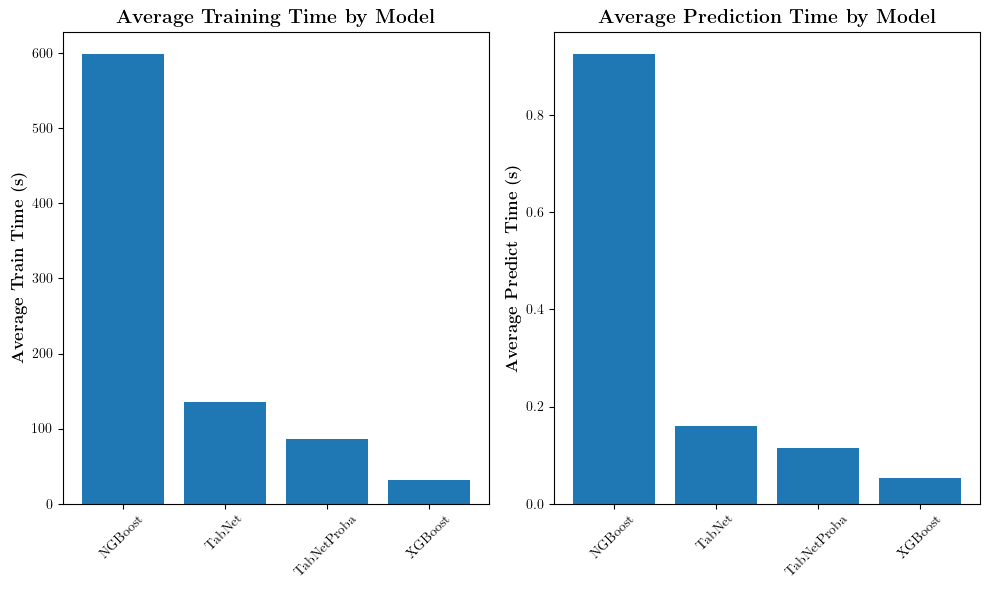

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
df = pd.read_csv("runtime_results.csv")

overall_avg_times = df.groupby('Model')[['Train Time (s)', 'Predict Time (s)']].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
})
plt.subplot(1, 2, 1)
plt.bar(overall_avg_times['Model'], overall_avg_times['Train Time (s)'])
#plt.xlabel(r"\textbf{Model}", fontsize=12)
plt.ylabel(r"\textbf{Average Train Time (s)}", fontsize=12)
plt.title(r"\textbf{Average Training Time by Model}", fontsize=14)
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(overall_avg_times['Model'], overall_avg_times['Predict Time (s)'])
#plt.xlabel(r"\textbf{Model}", fontsize=12)
plt.ylabel(r"\textbf{Average Predict Time (s)}", fontsize=12)
plt.title(r"\textbf{Average Prediction Time by Model}", fontsize=14)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("../../results/figures/avgmodel_times.pdf", dpi=300, bbox_inches='tight')
plt.show()
